# BraTS late fusion project

## Import

In [1]:
!pip install torchio
!pip install monai

In [2]:
import os
import json
import time
import random
from glob import glob
from subprocess import call

import nibabel as nib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from joblib import Parallel, delayed
from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import torchio as tio

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## EDA

### Slice

In [4]:
def load_specific_patient_data(patient_id):
    """
    Load the segmentation data for a specific patient.

    Parameters:
    patient_id (str): The ID of the patient.

    Returns:
    np.ndarray: The segmentation data of the patient.
    """
    patient_path = os.path.join(data_path, patient_id)
    lbl = nib.load(os.path.join(patient_path, f"{patient_id}-seg.nii.gz")).get_fdata().astype(np.uint8)
    return lbl

def load_patient_data(patient_id, sequences = ["t2w", "t2f", "t1n", "t1c"]):
    """
    Load the MRI data and segmentation for a specific patient.

    Parameters:
    patient_id (str): The ID of the patient.
    sequences (list of str): List of MRI sequences to load.

    Returns:
    tuple: A tuple containing the MRI data (list of np.ndarray) and the segmentation data (np.ndarray).
    """
    patient_path = os.path.join(data_path, patient_id)
    imgs = [nib.load(os.path.join(patient_path, f"{patient_id}-{seq}.nii.gz")).get_fdata().astype(np.float32)[:, :, 75] for seq in sequences]
    lbl = nib.load(os.path.join(patient_path, f"{patient_id}-seg.nii.gz")).get_fdata().astype(np.uint8)[:, :, 75]
    return imgs, lbl

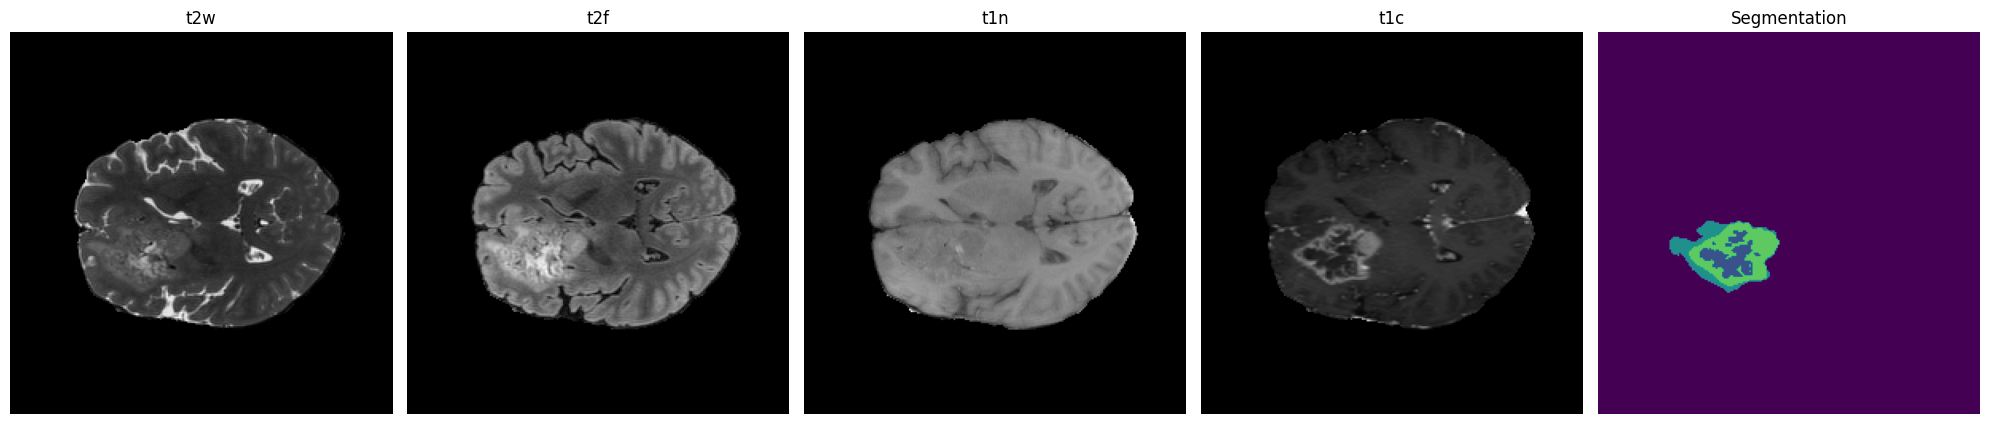

In [5]:
data_path = "/content/drive/MyDrive/Brats/Brats_Data"

# Exemple d'utilisation avec un patient spécifique
patient_id = "BraTS-GLI-00000-000"
imgs, lbl = load_patient_data(patient_id)

# Affichage des images et du masque de segmentation
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))
sequences = ["t2w", "t2f", "t1n", "t1c"]
for i, img in enumerate(imgs):
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(sequences[i])
    ax[i].axis('off')
ax[-1].imshow(lbl, cmap='viridis', vmin=0, vmax=4)
ax[-1].set_title("Segmentation")
ax[-1].axis('off')
plt.tight_layout()
plt.show()

### 3D

In [6]:
def load_specific_patient_label(patient_id, sequence):
    """
    Load the segmentation label for a specific patient and create a 3D scatter plot of the labeled voxels.

    Parameters:
    patient_id (str): The ID of the patient.
    sequence (str): The MRI sequence to load.

    Returns:
    plotly.graph_objs._figure.Figure: A 3D scatter plot of the labeled voxels.
    """
    patient_path = os.path.join(data_path, patient_id)
    lbl = nib.load(os.path.join(patient_path, f"{patient_id}-seg.nii.gz")).get_fdata().astype(np.uint8)

    # Get the coordinates of the labeled voxels
    x, y, z = np.where(lbl > 0)

    # Create a scatter plot of the labeled voxels
    scatter = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=2,
            color=lbl[x, y, z],
            colorscale='Viridis',
            opacity=0.2
        )
    )

    fig = go.Figure(data=[scatter])

    fig.update_layout(scene=dict(aspectmode='data'))

    return fig

patient_id = "BraTS-GLI-00005-000"
sequence = "t1n"
fig = load_specific_patient_label(patient_id, sequence)
fig.show()

### Label Distribution

In [7]:
patient_sample = random.sample(os.listdir(data_path), 5)

labels = []
for patient_id in patient_sample:
    lbl = load_specific_patient_data(patient_id)
    labels.append(lbl)

labels = np.concatenate(labels)
label_counts = np.bincount(labels.flatten())
total_voxels = labels.size
label_proportions = label_counts / total_voxels * 100

for i, proportion in enumerate(label_proportions):
    print(f"Label {i}: {proportion:.2f}%")

Label 0: 99.34%
Label 1: 0.09%
Label 2: 0.41%
Label 3: 0.16%


## Preprocessing

#### Augmentations without torchio

In [8]:
import numpy as np
import scipy.ndimage as ndi

def random_flip(image, axis):
    """Randomly flip an image along a given axis.

    Args:
        image (numpy.ndarray): The input image.
        axis (int): The axis along which to flip the image.

    Returns:
        numpy.ndarray: The flipped image.
    """
    if np.random.rand() < 0.5:
        return np.flip(image, axis)
    else:
        return image

def random_rotate(image, angle_range):
    """Randomly rotate an image by a random angle within a given range.

    Args:
        image (numpy.ndarray): The input image.
        angle_range (tuple): The range of angles to rotate the image by.

    Returns:
        numpy.ndarray: The rotated image.
    """
    angle = np.random.uniform(*angle_range)
    return ndi.rotate(image, angle, reshape=False)

def random_scale(image, scale_range):
    """Randomly scale an image by a random factor within a given range.

    Args:
        image (numpy.ndarray): The input image.
        scale_range (tuple): The range of scaling factors to apply to the image.

    Returns:
        numpy.ndarray: The scaled image.
    """
    scale = np.random.uniform(*scale_range)
    return ndi.zoom(image, scale)

def random_noise(image, noise_range):
    """Add random Gaussian noise to an image.

    Args:
        image (numpy.ndarray): The input image.
        noise_range (tuple): The range of noise levels to add to the image.

    Returns:
        numpy.ndarray: The noisy image.
    """
    noise_level = np.random.uniform(*noise_range)
    noise = np.random.normal(scale=noise_level, size=image.shape)
    return image + noise

def random_blur(image, sigma_range):
    """Apply random Gaussian blur to an image.

    Args:
        image (numpy.ndarray): The input image.
        sigma_range (tuple): The range of standard deviations to use for the Gaussian blur.

    Returns:
        numpy.ndarray: The blurred image.
    """
    sigma = np.random.uniform(*sigma_range)
    return ndi.gaussian_filter(image, sigma)

def random_gamma(image, gamma_range):
    """Apply random gamma correction to an image.

    Args:
        image (numpy.ndarray): The input image.
        gamma_range (tuple): The range of gamma values to use for the gamma correction.

    Returns:
        numpy.ndarray: The gamma-corrected image.
    """
    gamma = np.random.uniform(*gamma_range)
    return np.power(image, gamma)

In [9]:
class BraTSDataset(Dataset):
    """
    A custom dataset class for the BraTS dataset.

    Attributes:
    root_dir (str): The root directory containing patient data.
    patients (list): A sorted list of patient IDs.
    transforms (tio.Compose): A composition of TorchIO transforms for data augmentation and preprocessing.
    """
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.patients = sorted(os.listdir(root_dir))
        self.transforms = tio.Compose([
            tio.Resample((1, 1, 1)),  # Rééchantillonnage à une résolution de 1x1x1 mm
            tio.CropOrPad((150, 150, 150)),  # Recadrage/padding pour obtenir une taille uniforme
            tio.RandomFlip(axes=(0, 1, 2), flip_probability=0.5),
            tio.RandomAffine(scales=(1.0, 1.4), degrees=0, isotropic=False, image_interpolation='bspline'),
            tio.RandomNoise(mean=0, std=(0, 0.33), p=0.15),
            tio.RandomBlur(std=(0.5, 1.5), p=0.15),
            tio.RandomGamma(log_gamma=(0.7, 1.3), p=0.15),
            tio.RescaleIntensity(out_min_max=(0, 1))
        ])

    def __len__(self):
        return len(self.patients)

    def __getitem__(self, idx):
        patient_path = os.path.join(self.root_dir, self.patients[idx])
        images = []
        for modality in ['t1n', 't1c', 't2w', 't2f']:
            img_path = os.path.join(patient_path, f'{self.patients[idx]}-{modality}.nii.gz')
            img = nib.load(img_path).get_fdata()
            images.append(img)

        images = torch.stack([torch.tensor(image, dtype=torch.float32) for image in images])

        complete_mask_path = os.path.join(patient_path, f'{self.patients[idx]}-seg.nii.gz')
        complete_mask = nib.load(complete_mask_path).get_fdata()
        complete_mask = torch.tensor(complete_mask, dtype=torch.float32).unsqueeze(0)

        core_mask = (complete_mask == 1) | (complete_mask == 3)
        enhancing_mask = (complete_mask == 3)

        subject = tio.Subject(
            t1n=tio.ScalarImage(tensor=images[0:1]),
            t1c=tio.ScalarImage(tensor=images[1:2]),
            t2w=tio.ScalarImage(tensor=images[2:3]),
            t2f=tio.ScalarImage(tensor=images[3:4]),
            complete_mask=tio.LabelMap(tensor=complete_mask),
            core_mask=tio.LabelMap(tensor=core_mask),
            enhancing_mask=tio.LabelMap(tensor=enhancing_mask)
        )
        transformed = self.transforms(subject)
        return transformed.t1n.data, transformed.t1c.data, transformed.t2w.data, transformed.t2f.data, transformed.complete_mask.data, transformed.core_mask.data, transformed.enhancing_mask.data

root_dir = '/content/drive/MyDrive/Brats/Brats_Data/'
dataset = BraTSDataset(root_dir)

train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.3, random_state=42)
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = DataLoader(dataset, batch_size=2, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=2, sampler=test_sampler)

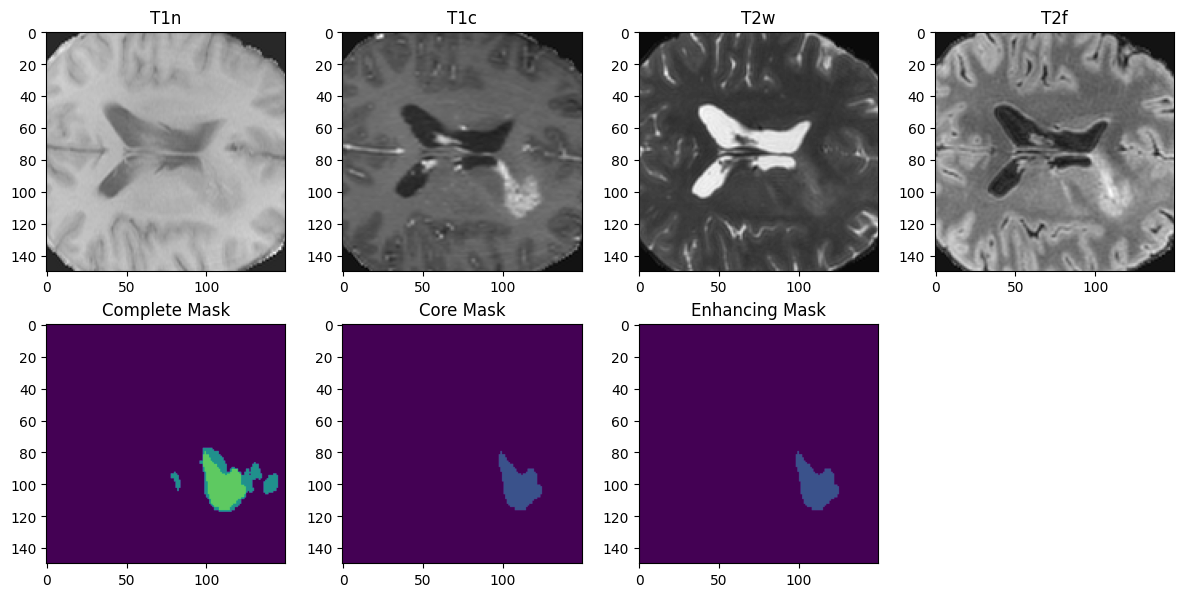

In [10]:
def visualize_augmented_data(dataset, idx):
    """
    Visualize the augmented data for a given index.

    Args:
    dataset (BraTSDataset): An instance of the BraTSDataset class.
    idx (int): The index of the data sample to visualize.
    """
    t1n, t1c, t2w, t2f, complete_mask, core_mask, enhancing_mask = dataset[idx]

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes[0, 0].imshow(t1n[0, :, :, 64], cmap='gray')
    axes[0, 0].set_title('T1n')
    axes[0, 1].imshow(t1c[0, :, :, 64], cmap='gray')
    axes[0, 1].set_title('T1c')
    axes[0, 2].imshow(t2w[0, :, :, 64], cmap='gray')
    axes[0, 2].set_title('T2w')
    axes[0, 3].imshow(t2f[0, :, :, 64], cmap='gray')
    axes[0, 3].set_title('T2f')
    axes[1, 0].imshow(complete_mask[0, :, :, 64], cmap='viridis', vmin=0, vmax=4)
    axes[1, 0].set_title('Complete Mask')
    axes[1, 1].imshow(core_mask[0, :, :, 64], cmap='viridis', vmin=0, vmax=4)
    axes[1, 1].set_title('Core Mask')
    axes[1, 2].imshow(enhancing_mask[0, :, :, 64], cmap='viridis', vmin=0, vmax=4)
    axes[1, 2].set_title('Enhancing Mask')
    axes[1, 3].axis('off')
    plt.tight_layout()
    plt.show()

visualize_augmented_data(dataset, idx=0)

## Training & Eval

In [11]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torch.utils.checkpoint import checkpoint
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from monai.losses import DiceLoss
from scipy.spatial.distance import directed_hausdorff
import torchio as tio

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
class DoubleConv(nn.Module):
    """
    A module for a double convolutional block with batch normalization and ReLU activation.
    """
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet3D(nn.Module):
    """
    A 3D U-Net architecture for volumetric segmentation.
    """
    def __init__(self, in_channels, out_channels):
        super(UNet3D, self).__init__()
        self.encoder1 = DoubleConv(in_channels, 16)
        self.pool1 = nn.MaxPool3d(2)
        self.encoder2 = DoubleConv(16, 32)
        self.pool2 = nn.MaxPool3d(2)
        self.encoder3 = DoubleConv(32, 64)
        self.pool3 = nn.MaxPool3d(2)
        self.encoder4 = DoubleConv(64, 128)
        self.pool4 = nn.MaxPool3d(2)
        self.bottleneck = DoubleConv(128, 256)
        self.upconv4 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)

        self.decoder4 = DoubleConv(256, 128)
        self.upconv3 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.decoder3 = DoubleConv(128, 64)
        self.upconv2 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.decoder2 = DoubleConv(64, 32)
        self.upconv1 = nn.ConvTranspose3d(32, 16, kernel_size=2, stride=2)
        self.decoder1 = DoubleConv(32, 16)
        self.final_conv = nn.Conv3d(16, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        bottleneck = self.bottleneck(self.pool4(enc4))
        dec4 = self.upconv4(bottleneck)
        dec4 = self._crop_and_concat(dec4, enc4)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = self._crop_and_concat(dec3, enc3)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = self._crop_and_concat(dec2, enc2)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = self._crop_and_concat(dec1, enc1)
        dec1 = self.decoder1(dec1)
        return self.final_conv(dec1)

    def _crop_and_concat(self, upsampled, bypass):
        """
        Crop and concatenate the upsampled and bypass tensors.

        Parameters:
        upsampled (torch.Tensor): The upsampled tensor.
        bypass (torch.Tensor): The bypass tensor from the encoder path.

        Returns:
        torch.Tensor: The concatenated tensor.
        """
        if upsampled.size() != bypass.size():
            diffZ = bypass.size()[2] - upsampled.size()[2]
            diffY = bypass.size()[3] - upsampled.size()[3]
            diffX = bypass.size()[4] - upsampled.size()[4]
            upsampled = nn.functional.pad(upsampled, [diffX // 2, diffX - diffX // 2,
                                                      diffY // 2, diffY - diffY // 2,
                                                      diffZ // 2, diffZ - diffZ // 2])
        return torch.cat([bypass, upsampled], dim=1)

In [13]:
def hausdorff_distance(pred, target):
    """
    Calculate the 95th percentile Hausdorff distance between the predicted and target masks.

    Parameters:
    pred (torch.Tensor): Predicted mask.
    target (torch.Tensor): Ground truth mask.

    Returns:
    float: The 95th percentile Hausdorff distance.
    """
    pred = pred.cpu().numpy().astype(bool)
    target = target.cpu().numpy().astype(bool)
    pred_coords = np.column_stack(np.where(pred))
    target_coords = np.column_stack(np.where(target))
    hd1 = directed_hausdorff(pred_coords, target_coords)[0]
    hd2 = directed_hausdorff(target_coords, pred_coords)[0]
    hd95 = max(hd1, hd2)
    return hd95

def dice_coefficient(pred, target, smooth=1e-5):
    """
    Calculate the Dice coefficient between the predicted and target masks.

    Parameters:
    pred (torch.Tensor): Predicted mask.
    target (torch.Tensor): Ground truth mask.
    smooth (float): Smoothing factor to avoid division by zero.

    Returns:
    float: The Dice coefficient.
    """
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return (2. * intersection + smooth) / (union + smooth)

class DiceLoss(nn.Module):
    """
    A custom loss function that calculates the Dice loss.
    """
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, pred, target):
        smooth = 1.0
        intersection = (pred * target).sum()
        return 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))

class RegionLoss(nn.Module):
    """
    A custom loss function that calculates the region loss using a combination of binary cross-entropy and Dice loss.
    """
    def __init__(self, num_regions):
        super(RegionLoss, self).__init__()
        self.num_regions = num_regions
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.dice_loss = DiceLoss()

    def forward(self, pred, target):
        loss = 0.0
        for i in range(self.num_regions):
            pred_region = pred[:, i, :, :, :]
            target_region = target[:, i, :, :, :]
            bce_region_loss = self.bce_loss(pred_region, target_region)
            dice_region_loss = self.dice_loss(pred_region, target_region)
            loss += bce_region_loss + dice_region_loss
        return loss / self.num_regions

In [14]:
def evaluate_model(model, data_loader, device):
    """
    Evaluate the model on the provided data loader.

    Parameters:
    model (nn.Module): The segmentation model to evaluate.
    data_loader (DataLoader): DataLoader for the evaluation dataset.
    device (torch.device): Device to run the evaluation on.

    Returns:
    tuple: Average Dice scores for complete tumor, tumor core, and enhancing tumor.
    """
    model.eval()
    complete_dice_scores = []
    core_dice_scores = []
    enhancing_dice_scores = []
    complete_hd95_scores = []
    core_hd95_scores = []
    enhancing_hd95_scores = []

    with torch.no_grad():
        for batch in data_loader:
            _, _, _, _, complete_mask, core_mask, enhancing_mask = [x.to(device) for x in batch]
            inputs = batch[modalities.index(modality)].to(device)
            outputs = model(inputs)
            complete_pred, core_pred, enhancing_pred = torch.split(outputs, 1, dim=1)

            complete_dice_score = dice_coefficient(complete_pred, complete_mask)
            core_dice_score = dice_coefficient(core_pred, core_mask)
            enhancing_dice_score = dice_coefficient(enhancing_pred, enhancing_mask)

            complete_dice_scores.append(complete_dice_score.item())
            core_dice_scores.append(core_dice_score.item())
            enhancing_dice_scores.append(enhancing_dice_score.item())

    avg_complete_dice = sum(complete_dice_scores) / len(complete_dice_scores)
    avg_core_dice = sum(core_dice_scores) / len(core_dice_scores)
    avg_enhancing_dice = sum(enhancing_dice_scores) / len(enhancing_dice_scores)

    return avg_complete_dice, avg_core_dice, avg_enhancing_dice

modalities = ['t1n', 't1c', 't2w', 't2f']

for modality in modalities:
    model = UNet3D(in_channels=1, out_channels=3).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    loss_function = nn.BCEWithLogitsLoss()
    scaler = GradScaler()

    num_epochs = 5
    best_loss = float('inf')
    patience, trials = 4, 0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch in tqdm(train_loader):
            _, _, _, _, complete_mask, core_mask, enhancing_mask = [x.to(device) for x in batch]
            inputs = batch[modalities.index(modality)].to(device)

            with autocast():
                outputs = model(inputs)
                complete_pred, core_pred, enhancing_pred = torch.split(outputs, 1, dim=1)
                complete_loss = loss_function(complete_pred, complete_mask)
                core_loss = loss_function(core_pred, core_mask)
                enhancing_loss = loss_function(enhancing_pred, enhancing_mask)
                loss = complete_loss + core_loss + enhancing_loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

            torch.cuda.empty_cache()

        epoch_loss /= len(train_loader)
        print(f'Modality: {modality}, Epoch {epoch + 1}, Loss: {epoch_loss:.4f}')

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            trials = 0
            torch.save(model.state_dict(), f'model_{modality}.pth')
        else:
            trials += 1
            if trials >= patience:
                print("Early stopping")
                break

    complete_dice, core_dice, enhancing_dice = evaluate_model(model, test_loader, device)
    print(f'Modality: {modality}, Complete Dice: {complete_dice:.4f}, Core Dice: {core_dice:.4f}, Enhancing Dice: {enhancing_dice:.4f}')
    #print(f'Modality: {modality}, Complete HD95: {complete_hd95:.4f}, Core HD95: {core_hd95:.4f}, Enhancing HD95: {enhancing_hd95:.4f}')

100%|██████████| 5/5 [00:40<00:00,  8.15s/it]


Modality: t1n, Epoch 1, Loss: 1.9421


100%|██████████| 5/5 [00:38<00:00,  7.78s/it]


Modality: t1n, Epoch 2, Loss: 1.8928


100%|██████████| 5/5 [00:39<00:00,  7.99s/it]


Modality: t1n, Epoch 3, Loss: 1.8672


100%|██████████| 5/5 [00:39<00:00,  7.89s/it]


Modality: t1n, Epoch 4, Loss: 1.8312


100%|██████████| 5/5 [00:39<00:00,  7.95s/it]


Modality: t1n, Epoch 5, Loss: 1.8000
Modality: t1n, Complete Dice: 0.0026, Core Dice: 0.0090, Enhancing Dice: 0.0109


100%|██████████| 5/5 [00:39<00:00,  7.80s/it]


Modality: t1c, Epoch 1, Loss: 2.0312


100%|██████████| 5/5 [00:39<00:00,  7.98s/it]


Modality: t1c, Epoch 2, Loss: 1.9799


100%|██████████| 5/5 [00:39<00:00,  7.96s/it]


Modality: t1c, Epoch 3, Loss: 1.9237


100%|██████████| 5/5 [00:39<00:00,  7.82s/it]


Modality: t1c, Epoch 4, Loss: 1.8859


100%|██████████| 5/5 [00:39<00:00,  7.98s/it]


Modality: t1c, Epoch 5, Loss: 1.8544
Modality: t1c, Complete Dice: -1.2223, Core Dice: 0.0242, Enhancing Dice: 0.0036


100%|██████████| 5/5 [00:39<00:00,  7.85s/it]


Modality: t2w, Epoch 1, Loss: 2.0383


100%|██████████| 5/5 [00:39<00:00,  7.90s/it]


Modality: t2w, Epoch 2, Loss: 1.9779


100%|██████████| 5/5 [00:39<00:00,  7.94s/it]


Modality: t2w, Epoch 3, Loss: 1.9279


100%|██████████| 5/5 [00:38<00:00,  7.74s/it]


Modality: t2w, Epoch 4, Loss: 1.8862


100%|██████████| 5/5 [00:39<00:00,  7.82s/it]


Modality: t2w, Epoch 5, Loss: 1.8371
Modality: t2w, Complete Dice: 0.1581, Core Dice: 0.0234, Enhancing Dice: 0.0145


100%|██████████| 5/5 [00:40<00:00,  8.04s/it]


Modality: t2f, Epoch 1, Loss: 2.0865


100%|██████████| 5/5 [00:39<00:00,  7.90s/it]


Modality: t2f, Epoch 2, Loss: 1.9945


100%|██████████| 5/5 [00:38<00:00,  7.71s/it]


Modality: t2f, Epoch 3, Loss: 1.9620


100%|██████████| 5/5 [00:39<00:00,  7.91s/it]


Modality: t2f, Epoch 4, Loss: 1.8827


100%|██████████| 5/5 [00:39<00:00,  7.92s/it]


Modality: t2f, Epoch 5, Loss: 1.8218
Modality: t2f, Complete Dice: 0.1216, Core Dice: 0.0162, Enhancing Dice: -0.0109


## Fusion Evaluation

In [22]:
def average_fusion(predictions):
    """
    Perform average fusion on a list of predictions.

    Parameters:
    predictions (list of torch.Tensor): List of predicted segmentation masks.

    Returns:
    torch.Tensor: The fused prediction.
    """
    return torch.mean(torch.stack(predictions), dim=0)

def majority_voting(predictions):
    """
    Perform majority voting fusion on a list of predictions.

    Parameters:
    predictions (list of torch.Tensor): List of predicted segmentation masks.

    Returns:
    torch.Tensor: The fused prediction based on majority voting.
    """
    stacked_preds = torch.stack(predictions)
    vote_result = torch.sum(stacked_preds, dim=0)
    majority_vote = (vote_result > (len(predictions) / 2)).float()
    return majority_vote

def fusion_network(predictions):
    """
    Perform fusion using a small neural network.

    Parameters:
    predictions (list of torch.Tensor): List of predicted segmentation masks.

    Returns:
    torch.Tensor: The fused prediction.
    """
    inputs = torch.cat(predictions, dim=1)
    fusion_model = nn.Sequential(
        nn.Conv3d(len(predictions) * predictions[0].shape[1], 3, kernel_size=1),
        nn.Sigmoid()
    ).to(device)
    return fusion_model(inputs)

def maximum_fusion(predictions):
    """
    Perform maximum fusion on a list of predictions.
    """
    return torch.max(torch.stack(predictions), dim=0)[0]

def weighted_average_fusion(predictions, weights):
    """
    Perform weighted average fusion on a list of predictions.

    Parameters:
    predictions (list of torch.Tensor): List of predicted segmentation masks.
    weights (list of float): List of weights corresponding to each prediction.

    Returns:
    torch.Tensor: The fused prediction based on weighted average.
    """
    weighted_predictions = [predictions[i] * weights[i] for i in range(len(predictions))]
    return torch.sum(torch.stack(weighted_predictions), dim=0)

def soft_voting(predictions):
    """
    Perform soft voting fusion on a list of predictions.
    """
    stacked_preds = torch.stack(predictions)
    return torch.mean(stacked_preds, dim=0)

def evaluate_fusion(method, data_loader, device, models):
    """
    Evaluate a fusion method on a validation dataset.

    Parameters:
    method (function): The fusion method to be evaluated.
    data_loader (DataLoader): DataLoader for the validation set.
    device (torch.device): Device to run the evaluation on (CPU or GPU).
    models (list of nn.Module): List of trained models for each modality.

    Returns:
    tuple: Average Dice scores for complete, core, and enhancing tumor masks.
    """
    for model in models:
        model.eval()
    complete_dice_scores = []
    core_dice_scores = []
    enhancing_dice_scores = []

    with torch.no_grad():
        for batch in data_loader:
            _, _, _, _, complete_mask, core_mask, enhancing_mask = [x.to(device) for x in batch]
            inputs = [batch[i].to(device) for i in range(len(modalities))]
            predictions = [models[i](inputs[i]) for i in range(len(modalities))]
            fused_prediction = method(predictions)
            complete_pred, core_pred, enhancing_pred = torch.split(fused_prediction, 1, dim=1)

            complete_dice_score = dice_coefficient(complete_pred, complete_mask)
            core_dice_score = dice_coefficient(core_pred, core_mask)
            enhancing_dice_score = dice_coefficient(enhancing_pred, enhancing_mask)

            complete_dice_scores.append(complete_dice_score.item())
            core_dice_scores.append(core_dice_score.item())
            enhancing_dice_scores.append(enhancing_dice_score.item())

    avg_complete_dice = sum(complete_dice_scores) / len(complete_dice_scores)
    avg_core_dice = sum(core_dice_scores) / len(core_dice_scores)
    avg_enhancing_dice = sum(enhancing_dice_scores) / len(enhancing_dice_scores)

    return avg_complete_dice, avg_core_dice, avg_enhancing_dice

In [23]:
modalities = ['t1n', 't1c', 't2w', 't2f']

models = []
for modality in modalities:
    model = UNet3D(in_channels=1, out_channels=3).to(device)
    model.load_state_dict(torch.load(f'model_{modality}.pth'))
    models.append(model)

methods = {
    'Fusion Network': fusion_network,
    'Average': average_fusion,
    'Majority Voting': majority_voting,
    'Maximum': maximum_fusion,
    'Soft Voting': soft_voting,
    'Weighted Average': weighted_average_fusion
}

weights = [0.20, 0.30, 0.20, 0.30]

for name, method in methods.items():
    if name == 'Weighted Average':
        complete_dice, core_dice, enhancing_dice = evaluate_fusion(lambda predictions: method(predictions, weights), test_loader, device, models)
    else:
        complete_dice, core_dice, enhancing_dice = evaluate_fusion(method, test_loader, device, models)
    print(f'Method: {name}, Complete Dice: {complete_dice:.4f}, Core Dice: {core_dice:.4f}, Enhancing Dice: {enhancing_dice:.4f}')

Method: Fusion Network, Complete Dice: 0.1052, Core Dice: 0.0147, Enhancing Dice: 0.0110
Method: Average, Complete Dice: 0.7733, Core Dice: 0.0214, Enhancing Dice: 0.0065
Method: Majority Voting, Complete Dice: 0.0000, Core Dice: 0.0000, Enhancing Dice: 0.0000
Method: Maximum, Complete Dice: 0.1215, Core Dice: 0.0128, Enhancing Dice: 0.0094
Method: Soft Voting, Complete Dice: 0.0815, Core Dice: 0.0170, Enhancing Dice: 0.0011
Method: Weighted Average, Complete Dice: 2.0520, Core Dice: 0.0158, Enhancing Dice: 0.0130


## Visual Evaluation

In [1]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import torch.nn.functional as F

def visualize_fusion_results(method, test_loader, device, models):
    """
    Visualize the ground truth and predictions for a given fusion method using only the t1c and t2f modalities.

    Args:
    method (callable): A fusion method that takes a list of predictions as input and returns a fused prediction.
    test_loader (DataLoader): A DataLoader object that provides batches of test data.
    device (torch.device): The device on which to perform computations.
    models (list): A list of trained models, one for each modality.
    """
    # Set the models to evaluation mode
    for model in models:
        model.eval()

    # Get a batch of test data
    batch = next(iter(test_loader))
    _, _, _, _, complete_mask, core_mask, enhancing_mask = [x.to(device) for x in batch]

    # Get the predictions for the t1c and t2f modalities
    t1c_prediction = models[modalities.index('t1c')](batch[modalities.index('t1c')].to(device))
    t2f_prediction = models[modalities.index('t2f')](batch[modalities.index('t2f')].to(device))

    # Get the fused prediction
    fused_prediction = method([t1c_prediction, t2f_prediction])

    # Apply a threshold to the probability maps to obtain binary masks
    fused_prediction = F.softmax(fused_prediction, dim=1)
    fused_prediction = (fused_prediction > 0).float()

    # Convert the predictions and ground truth to numpy arrays
    fused_prediction = fused_prediction.detach().cpu().numpy()
    complete_mask = complete_mask.detach().cpu().numpy()
    core_mask = core_mask.detach().cpu().numpy()
    enhancing_mask = enhancing_mask.detach().cpu().numpy()

    # Visualize the ground truth and predictions
    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    axes[0, 0].imshow(fused_prediction[0, 0, :, :, 64], cmap='gray')
    axes[0, 0].set_title('Complete Prediction')
    axes[0, 1].imshow(fused_prediction[0, 1, :, :, 64], cmap='gray')
    axes[0, 1].set_title('Core Prediction')
    axes[0, 2].imshow(fused_prediction[0, 2, :, :, 64], cmap='gray')
    axes[0, 2].set_title('Enhancing Prediction')
    axes[1, 0].imshow(complete_mask[0, 0, :, :, 64], cmap='gray')
    axes[1, 0].set_title('Complete Ground Truth')
    axes[1, 1].imshow(core_mask[0, 0, :, :, 64], cmap='gray')
    axes[1, 1].set_title('Core Ground Truth')
    axes[1, 2].imshow(enhancing_mask[0, 0, :, :, 64], cmap='gray')
    axes[1, 2].set_title('Enhancing Ground Truth')
    axes[2, 0].axis('off')
    axes[2, 1].axis('off')
    axes[2, 2].axis('off')
    plt.tight_layout()
    plt.show()

visualize_fusion_results(methods['Average'], test_loader, device, models)

NameError: name 'methods' is not defined